# Start with Proof of Concept

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import neurokit2 as nk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# AdVitam ECG Data

In [2]:
physio_data = "../AdVitam/Exp2/Raw/Physio/Txt/NST01.txt"
physio_markers = "../AdVitam/Exp2/Raw/Physio/Txt/NST01-markers.txt"

# markers
physio_markers = pd.read_csv(physio_markers, header=2, sep="\t")

# physiological data
physio_data = pd.read_csv(
    physio_data,
    sep="\t",
    header=9,
    skiprows=[10],
    usecols=[0, 1, 2, 3],
)

# ECG data
nst01_ecg_data = physio_data[["CH2"]]
nst01_ecg_data = nst01_ecg_data.values.reshape(-1)

# Processing The Data

In [3]:
# Process ECG data
signals, info = nk.ecg_process(nst01_ecg_data, sampling_rate=1000)

# Add the timestamps to the signals data
timestamps = physio_data[["min"]].values.reshape(-1)
signals["Timestamps"] = timestamps

In [4]:
signals["Timestamps"] = pd.to_timedelta(signals["Timestamps"], unit="m")
# signals = signals.drop_duplicates(subset="Timestamps", keep="first")
signals = signals.set_index("Timestamps")
# signals = signals.resample("100ms").ffill()
# signals = signals.interpolate(method='linear')

In [5]:
# segment the data
baseline_start = pd.to_timedelta(physio_markers["Time(sec.):"][0], unit="s")
baseline_end = pd.to_timedelta(physio_markers["Time(sec.):"][1], unit="s")
baseline_data = signals[baseline_start:baseline_end]

# training
training_start = pd.to_timedelta(physio_markers["Time(sec.):"][2], unit="s")
training_end = pd.to_timedelta(physio_markers["Time(sec.):"][3], unit="s")
training_data = signals[training_start:training_end ]

# experiment
experiment_start = pd.to_timedelta(physio_markers['Time(sec.):'][4], unit='s')
experiment_end = pd.to_timedelta(physio_markers["Time(sec.):"][5], unit="s")
experiment_data = signals[experiment_start:experiment_end]

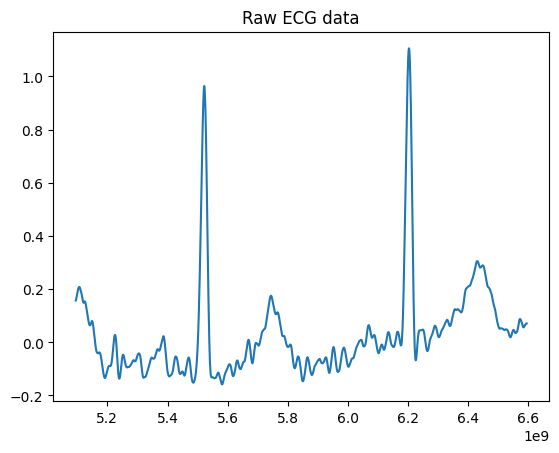

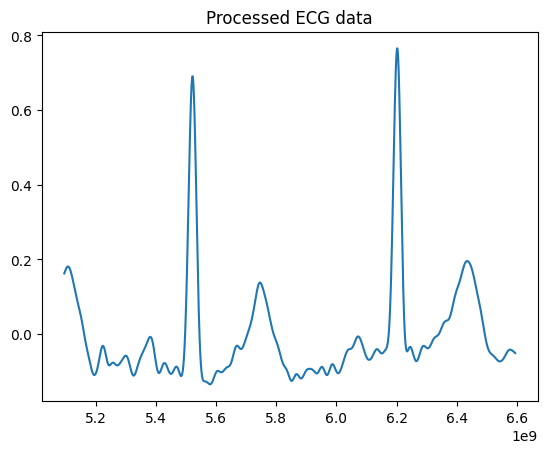

In [6]:
# plot raw ecg data
plt.plot(baseline_data["ECG_Raw"][1000:2500])
plt.title("Raw ECG data")
plt.show()

# plot processed ecg data
plt.plot(baseline_data["ECG_Clean"][1000:2500])
plt.title("Processed ECG data")
plt.show()

---

In [7]:
# baseline_data

In [8]:
baseline_ecg_data = baseline_data[["ECG_Clean", "ECG_R_Peaks"]]

In [9]:
baseline_ecg_data

,ECG_Clean,ECG_R_Peaks
Timestamps,,
0 days 00:00:04.095000,-0.112018,0
0 days 00:00:04.096002,-0.113866,0
0 days 00:00:04.096998,-0.115335,0
0 days 00:00:04.098000,-0.116461,0
0 days 00:00:04.099001999,-0.117290,0
...,...,...
0 days 00:05:05.314800,-0.082589,0
0 days 00:05:05.316000,-0.081389,0
0 days 00:05:05.317200,-0.080207,0


In [10]:
heartbeat = baseline_ecg_data.copy()

# remove the first peak
first_peak = heartbeat[heartbeat["ECG_R_Peaks"] == 1].index[0]
heartbeat = heartbeat[first_peak:]


ecg_beats = pd.DataFrame()
while True:
    # check if there are still peaks
    if len(heartbeat[heartbeat["ECG_R_Peaks"] == 1]) == 1:
        break

    # get the time of the first peak
    peak_time = heartbeat[heartbeat["ECG_R_Peaks"] == 1].index[1]
    beat = heartbeat[:peak_time].copy()

    # time of beat
    time = beat.index[0]

    beat.reset_index(inplace=True)
    beat.drop(columns=["Timestamps", "ECG_R_Peaks"], inplace=True)

    # downsample the beat to 140 samples
    single_beat_array = []
    skips = len(beat) / 140
    for i in range(0, 140):
        index_value = round(i * skips)
        single_beat_array.append(beat.iloc[index_value])
    single_beat_array = np.array(single_beat_array)
    single_beat_array = single_beat_array.reshape(-1)

    # add the beat as a row to the dataframe
    ecg_beats = pd.concat([ecg_beats, pd.DataFrame(single_beat_array).T])

    # plot the beat
    # plt.plot(single_beat_array)
    # plt.show()

    # remove the beat from the dataframe
    heartbeat = heartbeat[peak_time:]

In [11]:
ecg_beats

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,0.698446,0.631757,0.452458,0.271211,0.062970,-0.076754,-0.140680,-0.156501,-0.158335,-0.164153,...,-0.018900,-0.041831,-0.054402,-0.047670,-0.003312,0.097789,0.262827,0.473645,0.641305,0.790591
0,0.824040,0.742707,0.601061,0.387732,0.201170,0.098754,0.028776,0.000876,-0.007805,-0.012981,...,-0.096601,-0.108456,-0.111951,-0.098609,-0.048302,0.051886,0.170369,0.352981,0.536032,0.644686
0,0.689996,0.638092,0.483726,0.281748,0.129284,-0.012281,-0.090337,-0.120380,-0.126555,-0.127251,...,-0.050973,-0.046470,-0.041097,-0.030238,0.003940,0.085287,0.228759,0.380637,0.578975,0.725566
0,0.765007,0.696279,0.521380,0.305036,0.150587,0.019496,-0.037778,-0.045961,-0.037787,-0.034923,...,-0.049779,-0.055655,-0.061985,-0.054652,-0.015440,0.073663,0.220171,0.368780,0.558197,0.695392
0,0.729195,0.656855,0.482741,0.271399,0.092871,-0.014538,-0.052125,-0.063474,-0.063905,-0.069429,...,-0.083255,-0.087486,-0.080265,-0.053135,0.003928,0.078642,0.214858,0.390608,0.572776,0.707100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.682880,0.632661,0.480042,0.322170,0.135827,0.003726,-0.064667,-0.087331,-0.089873,-0.089504,...,-0.089518,-0.092605,-0.093446,-0.083854,-0.046667,0.038127,0.181441,0.369344,0.522423,0.664377
0,0.703038,0.638459,0.472482,0.266103,0.085411,-0.013598,-0.077487,-0.095124,-0.093928,-0.091676,...,-0.090380,-0.094270,-0.095585,-0.083930,-0.041845,0.050406,0.167490,0.357043,0.554332,0.696290
0,0.731184,0.658258,0.482681,0.268978,0.117273,-0.012873,-0.074104,-0.089620,-0.088303,-0.087840,...,-0.092998,-0.093639,-0.091970,-0.079775,-0.041885,0.041311,0.182234,0.330352,0.526420,0.676385
0,0.722327,0.663454,0.496231,0.282611,0.126345,-0.011408,-0.078549,-0.096885,-0.096048,-0.094709,...,-0.086208,-0.087571,-0.087324,-0.076091,-0.037257,0.049194,0.194309,0.344812,0.541040,0.687581


In [12]:
data = ecg_beats.values

# split the data into training and validation
train_data, val_data = train_test_split(
    data, test_size=0.2, random_state=21
)

In [13]:
# Normalize the data - Min Max Scaling
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
val_data = (val_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
val_data = tf.cast(val_data, tf.float32)

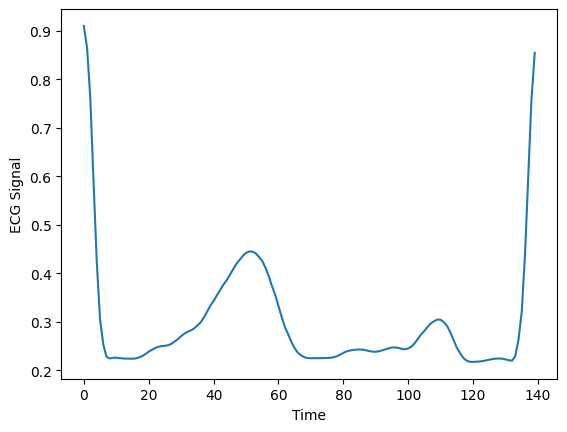

In [14]:
plt.plot(train_data[0], label=f"Heartbeat {i+1}")
plt.xlabel("Time")
plt.ylabel("ECG Signal")
plt.show()

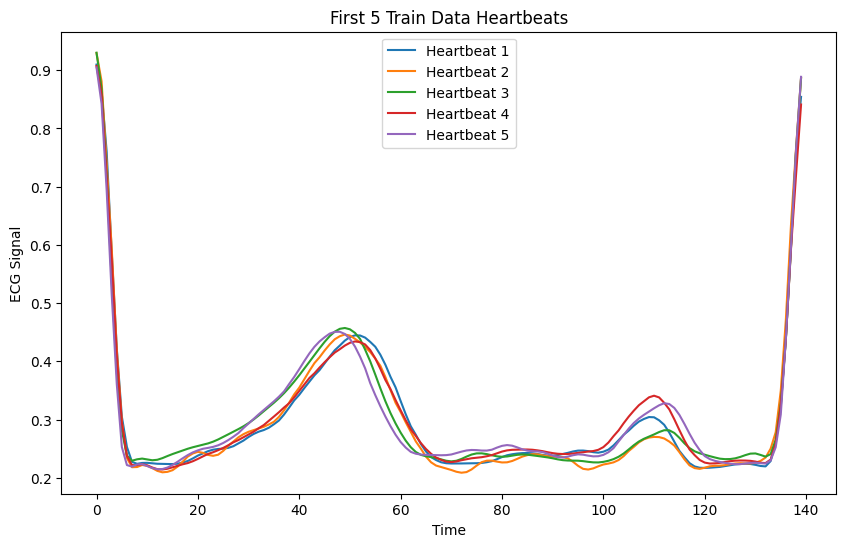

In [15]:
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(train_data[i], label=f"Heartbeat {i+1}")
plt.title("First 5 Train Data Heartbeats")
plt.xlabel("Time")
plt.ylabel("ECG Signal")
plt.legend()
plt.show()


In [16]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential(
            [
                layers.Dense(32, activation="relu"),
                layers.Dense(16, activation="relu"),
                layers.Dense(8, activation="relu"),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                layers.Dense(16, activation="relu"),
                layers.Dense(32, activation="relu"),
                layers.Dense(140, activation="sigmoid"),
            ]
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = AnomalyDetector()

autoencoder.compile(optimizer="adam", loss="mae")

In [17]:
history = autoencoder.fit(
    train_data,
    train_data,
    epochs=80,
    batch_size=512,
    validation_data=(val_data, val_data),
    shuffle=True,
)

Epoch 1/80
1/1 [==============================] - 0s 268ms/step - loss: 0.2237 - val_loss: 0.2227
Epoch 2/80
1/1 [==============================] - 0s 11ms/step - loss: 0.2232 - val_loss: 0.2223
Epoch 3/80
1/1 [==============================] - 0s 11ms/step - loss: 0.2227 - val_loss: 0.2217
Epoch 4/80
1/1 [==============================] - 0s 18ms/step - loss: 0.2222 - val_loss: 0.2211
Epoch 5/80
1/1 [==============================] - 0s 26ms/step - loss: 0.2216 - val_loss: 0.2205
Epoch 6/80
1/1 [==============================] - 0s 12ms/step - loss: 0.2210 - val_loss: 0.2198
Epoch 7/80
1/1 [==============================] - 0s 11ms/step - loss: 0.2203 - val_loss: 0.2190
Epoch 8/80
1/1 [==============================] - 0s 12ms/step - loss: 0.2195 - val_loss: 0.2181
Epoch 9/80
1/1 [==============================] - 0s 11ms/step - loss: 0.2186 - val_loss: 0.2171
Epoch 10/80
1/1 [==============================] - 0s 11ms/step - loss: 0.2176 - val_loss: 0.2160
Epoch 11/80
1/1 [===========

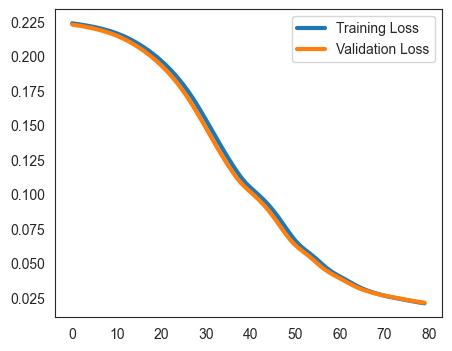

In [18]:
plt.figure(figsize=(5, 4))
sns.set_style("white")
plt.plot(history.history["loss"], label="Training Loss", linewidth=3.0)
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=3.0)
plt.legend()

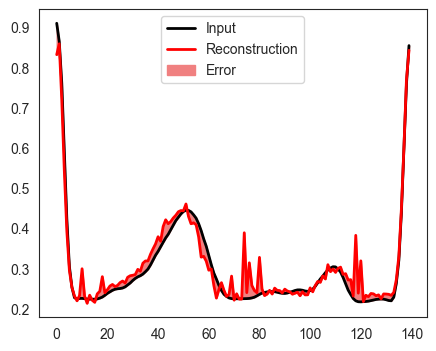

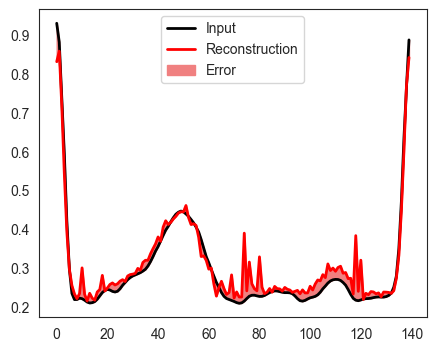

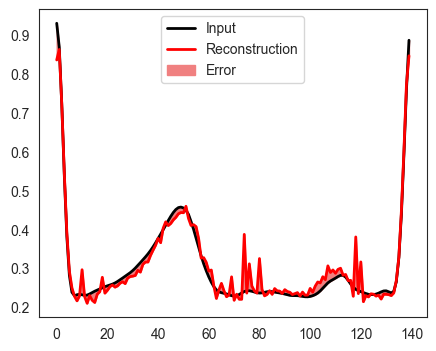

In [19]:
encoded_imgs = autoencoder.encoder(train_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

for i in range(0, 3):
    plt.figure(figsize=(5, 4))
    sns.set_style("white")
    plt.plot(train_data[i], "black", linewidth=2)
    plt.plot(decoded_imgs[i], "red", linewidth=2)
    plt.fill_between(np.arange(140), decoded_imgs[i], train_data[i], color="lightcoral")
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()

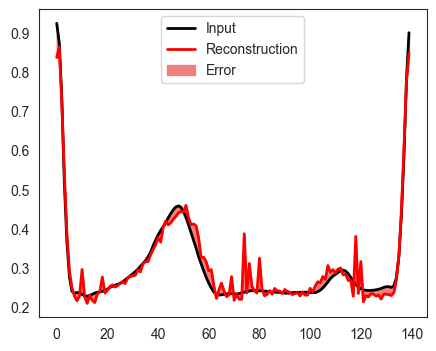

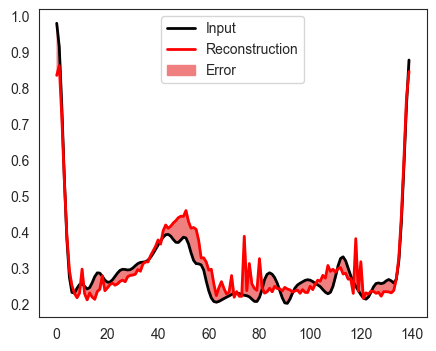

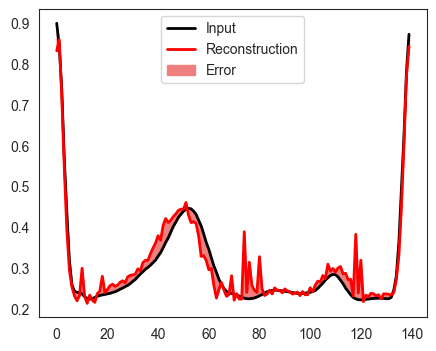

In [20]:
encoded_imgs = autoencoder.encoder(val_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

for i in range(0, 3):
    plt.figure(figsize=(5, 4))
    sns.set_style("white")
    plt.plot(val_data[i], "black", linewidth=2)
    plt.plot(decoded_imgs[i], "red", linewidth=2)
    plt.fill_between(np.arange(140), decoded_imgs[i], val_data[i], color="lightcoral")
    plt.legend(labels=["Input", "Reconstruction", "Error"])
    plt.show()

In [21]:
reconstructions = autoencoder.predict(train_data)
train_loss = tf.keras.losses.mae(reconstructions, train_data)
mean_loss = np.mean(train_loss)
mean_loss

11/11 [==============================] - 0s 427us/step


0.02037105

In [22]:
threshold = np.mean(train_loss) + (1.75 * np.std(train_loss))
print("Threshold: ", threshold)

Threshold:  0.03956631384789944


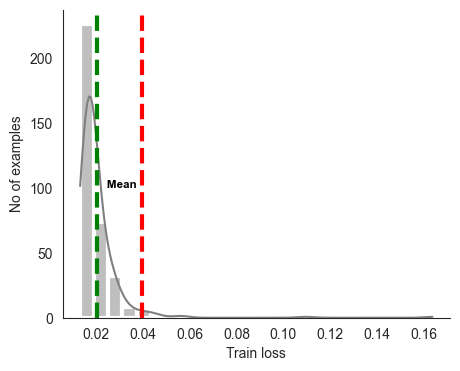

In [23]:
plt.figure(figsize=(5, 4))
sns.set_style("white")

# Normal distribution
sns.histplot(train_loss, bins=25, kde=True, color="grey", linewidth=3)
plt.axvline(x=np.mean(train_loss), color="g", linestyle="--", linewidth=3)
plt.text(
    np.mean(train_loss),
    100,
    "   Mean",
    horizontalalignment="left",
    size="small",
    color="black",
    weight="semibold",
)

# Threshold
plt.axvline(x=threshold, color="r", linestyle="--", linewidth=3)

plt.xlabel("Train loss")
plt.ylabel("No of examples")
sns.despine()